# Compressible problem: Inviscid Bump

This notebook provides a Python approach to setup and run the standard tutorial case [Inviscid Bump](https://su2code.github.io/tutorials/Inviscid_Bump/) and reading that case before getting here is highly recommended, since we will not be discussing all the points. The main goal is provide a full Python interface to the problem from case construction to post-processing. This is done through our package `cfdtoolbox` and [`pyvista`](https://docs.pyvista.org/getting-started/index.html), an excellent tool for VTK data rendering.

This tutorial assumes you are running this notebooks in some sort of Linux system (and that you are well versed in its usage), Ubuntu being the recommended distro given the ease of installing dependencies related to CFD. The following must be installed before proceeding with this notebook:

```
sudo apt install libgl1-mesa-glx xvfb
pip install --user pyvista ipyvtklink
```

Alternative approaches of VTK data rendering are discussed [here](https://stackoverflow.com/questions/56401123).

Since `cfdtoolbox` is under active development during preparation of these tutorials, we enable `autoreload` first.

In [1]:
%load_ext autoreload
%autoreload 2

Next we import `pyvista` and the subpackage `cfdtoolbox.su2.fields` required for preparing the case file.

In [2]:
import pyvista as pv
import cfdtoolbox.su2.fields as su

Next we configure `pv` to [display static images in notebook](https://docs.pyvista.org/user-guide/jupyter/index.html). We also start the display.

In [3]:
pv.set_jupyter_backend('static')
pv.start_xvfb()

Since I am running inside a JupyterHub instance, variables sourced in user profile (*e.g.* from `.bashrc`) are not visible, so a script is used for this end, you can check that in [environment.py](environment.py). Here we need those variables [related to SU2 to be available](https://su2code.github.io/docs_v7/SU2-Linux-MacOS/). Since SU2 has been compiled with Mutation++ support, shared libraries must also be sourced from `LD_LIBRARY_PATH`.  You can inspect the loading of this variables with `!env` in a code cell to execute system command.

If you have SU2 in your local path, you must comment-out the next line or edit the contents of environment file.

In [4]:
import environment as _

As will be the case for all tutorials in this series, we provide a *case* name under `cases/` directory. A good choice is to name it as this notebook itself. All the running will be done in that path and it is ignored by source control (`git` here). Also the case meshes are all stored under `meshes/` and are copied by `cfdtoolbox` to the working directory, so we provide its path here.

In [5]:
case_dir = "cases/su2-01-compressible-inviscid-bump"
case_mesh = "meshes/mesh_channel_256x128.su2"

## Case construction

In this section we show how to use `cfdtoolbox` to transform the [original case](https://github.com/su2code/Tutorials/tree/master/compressible_flow/Inviscid_Bump) into a Python script. This has the advantage to allow parametric generation of cases and other computations to be performed directly in case construction.

As stated in the [original tutorial](https://su2code.github.io/tutorials/Inviscid_Bump/) the goal of this case is to solve 2D Euler equations (so inviscid flow) with a multi-grid approach, so that you can learn how SU2 treats the application of boundary conditions through the use of *markers*. The problem is going to be simulated under subsonit conditions, so you could eventually treat it as *incompressible* instead. You are invited to modify the case to simulate transonic conditions later.

**Note:** in most cases, parameters that match the [master configuration file](https://github.com/su2code/SU2/blob/master/config_template.cfg) defaults are not kept in this tutorial.

We start with section *Direct, adjoint, and linearized problem definition* of default configuration file, which has been implemented in `cfdtoolbox.su2.fields.problem` module. In this module we define the physical model to be used by setting `SOLVER` to `EULER`. You can get help about any field by printing it. Whenever a field has been used in original case but is set to default we will leave it commented out.

**Note:** in Python `str` and `repr` functions provide different results, in the implementation of `cfdtoolbox` the string format `__str__` is used to provide the text as used to generate configuration file, while `__repr__` provides a long-description (if available). This is not a common or recommended practice but it seemed extremely nice for usage with notebooks since it is the latter that is cased when we leave a variable to be printed-out in the end of a cell.

In [6]:
su.problem.SOLVER.value = "EULER"

As of any CFD problem, visualization is of utmost importance. Using `pyvista` we provide below the rendering of problem mesh. Notice that names of *tags* are not supported by `meshio` package (who actually read the mesh because in this case it is not VTK), but that is quire useful for us cause we get to see names of these *markers* printed in warning messages: the system is composed of an inlet, a pair of upper and lower walls, and an outlet. From the `outline` property we can get a good guess of camera placement to see the mesh later.

In [7]:
grid = pv.read(case_mesh)
grid.outline()

    Surface tag  inlet will be replaced by 1
    Surface tag  lower_wall will be replaced by 2
    Surface tag  outlet will be replaced by 3
    Surface tag  upper_wall will be replaced by 4


PolyData,Information
N Cells,12
N Points,8
X Bounds,"0.000e+00, 3.000e+00"
Y Bounds,"0.000e+00, 1.000e+00"
Z Bounds,"0.000e+00, 0.000e+00"
N Arrays,0


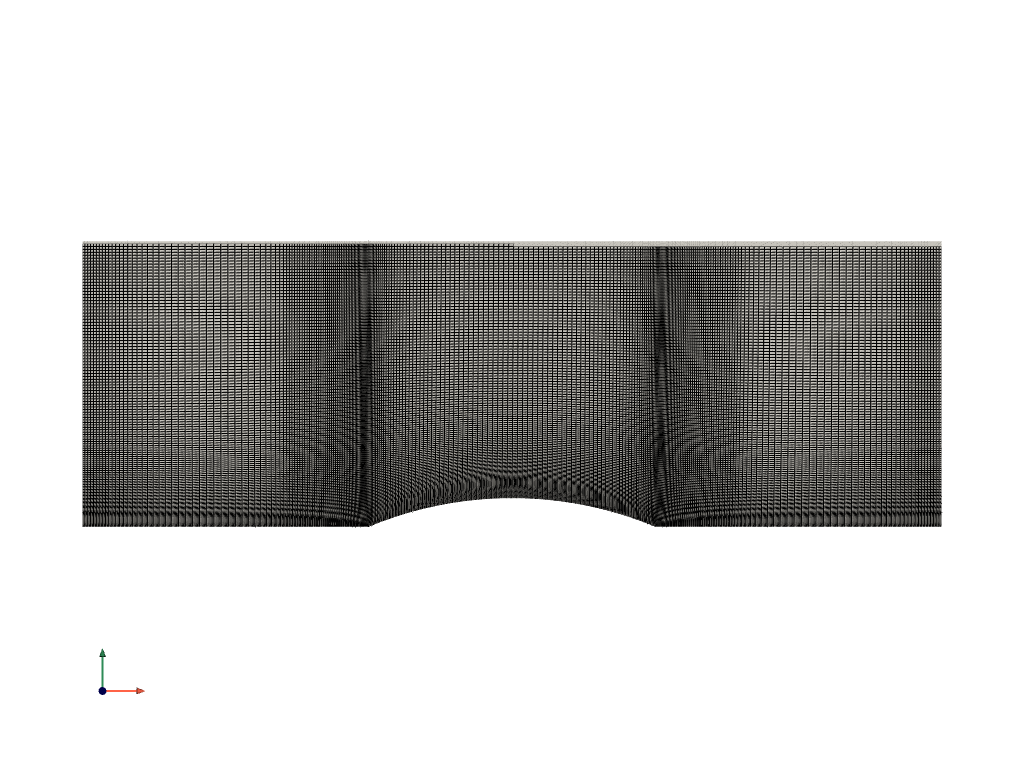

In [8]:
cpos = ((1.5, 0.5, 5.0),
        (1.5, 0.5, 0.0),
        (0.0, 0.0, 0.0))

grid.plot(cpos=cpos, show_edges=True, color="w", background="w")

In `pyvista` a broad range of mesh operations are possible. As we have seen, tags were transformed in numbers, which are actually stored in `su2:tag` cell data in the case of SU2 meshes. Using method `remove_cells` we can filter each of these conditions.

In [9]:
all_tags = grid.cell_data["su2:tag"]
external = grid.copy().remove_cells(all_tags == 0)
all_tags = external.cell_data["su2:tag"]

tag_inlet      = external.copy().remove_cells(all_tags != 1)
tag_lower_wall = external.copy().remove_cells(all_tags != 2)
tag_outlet     = external.copy().remove_cells(all_tags != 3)
tag_upper_wall = external.copy().remove_cells(all_tags != 4)

With these selections in hand we can use a more complex feature of `pyvista` to make a composite plot depicting each of these selected tags. A grid is also added to the image to provide the size of the system, which will later also be need to analyse the data.

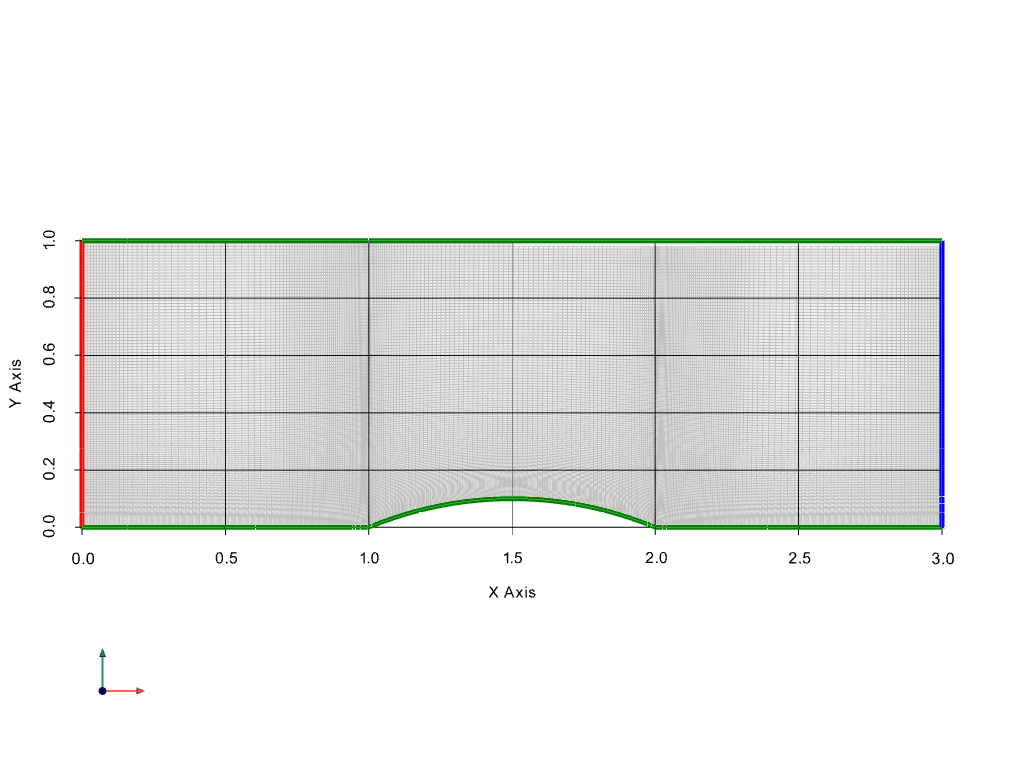

In [10]:
p = pv.Plotter(notebook=True)
p.add_mesh(grid.copy(), show_edges=True, color="w", opacity=0.95)
p.add_mesh(tag_inlet,      color="r", show_edges=True, line_width=5)
p.add_mesh(tag_lower_wall, color="g", show_edges=True, line_width=5)
p.add_mesh(tag_outlet,     color="b", show_edges=True, line_width=5)
p.add_mesh(tag_upper_wall, color="g", show_edges=True, line_width=5)
p.set_background(color="w")
p.show_grid(color="k")
p.add_axes()
p.show(cpos=cpos)

Each of these tags has to be attributed to a marker type in section *Boundary condition definition* as implemented in sub-module `boundary_condition`. Slip boundary is provided by `MARKER_EULER`, which receives as a tuple of arguments with the names of walls. In `INLET_TYPE` we use option `TOTAL_CONDITIONS`, *i.e* thermodynamic state and flow direction, the other options speaking by themselves and being complemented by the documentation printed below.

In [11]:
su.boundary_condition.MARKER_EULER.value = ("upper_wall", "lower_wall")
su.boundary_condition.INLET_TYPE.value = "TOTAL_CONDITIONS"
su.boundary_condition.MARKER_INLET.value = ("inlet", 288.6, 102010.0, 1.0, 0.0, 0.0)
su.boundary_condition.MARKER_OUTLET.value = ("outlet", 101300.0)

su.boundary_condition.MARKER_INLET

% Inlet boundary marker(s) with the following formats (NONE = no marker)
MARKER_INLET= (inlet, 288.6, 102010.0, 1.0, 0.0, 0.0)


Total Conditions:
    (inlet marker, total temp, total pressure, flow_direction_x,
     flow_direction_y, flow_direction_z, ... )
Mass Flow:
    (inlet marker, density, velocity magnitude, flow_direction_x,
     flow_direction_y, flow_direction_z, ... )
Inc. Velocity:
    (inlet marker, temperature, velocity magnitude, flow_direction_x,
     flow_direction_y, flow_direction_z, ... )
Inc. Pressure:
    (inlet marker, temperature, total pressure, flow_direction_x,
     flow_direction_y, flow_direction_z, ... )
In all cases `flow_direction` is a unit vector.

There is also a section *Surfaces identification* (sub-module `surfaces`) which allow us to specify a surface to save in a plotting file and thoses where possible objective functionals (drag, lift,...) are computed.

In [12]:
su.surfaces.MARKER_PLOTTING.value = ("lower_wall")
su.surfaces.MARKER_MONITORING.value = ("upper_wall", "lower_wall")

Numerical solutions are controlled in *Flow numerical method definition* `flow_numerical` section. Here we select and implicit scheme in time for stability and a [JST](https://su2code.github.io/docs_v7/Convective-Schemes/) convective scheme, which can be further parametrized in *Slope limiter and dissipation sensor definition* with `limiter.JST_SENSOR_COEFF`.

In [13]:
su.flow_numerical.CONV_NUM_METHOD_FLOW.value = "JST"
su.flow_numerical.TIME_DISCRE_FLOW.value = "EULER_IMPLICIT"

More parameters are provided in *Common parameters defining the numerical method* `common`, where we select adaptive *CFL* criteria for convergence control.

In [14]:
su.common.CFL_NUMBER.value = 50.0
su.common.CFL_ADAPT.value = "YES"
su.common.CFL_ADAPT_PARAM.value = (0.1, 2.0, 50.0, 1e10)

Next we handle section *Solver control*, implemented in sub-module `solver_control`. Here we provide a high total number of iterations `ITER` to find problem steady-state. Notice that if `CONV_RESIDUAL_MINVAL` logarithm of residual of property `CONV_FIELD` is reached before `ITER` the solver will stop and dump results. You can inspect what properties are available to set a stop criteria by running `SU2_CFD -d` inside the case, we will do that once the case is generated.

In [15]:
su.solver_control.ITER.value = 999999
su.solver_control.CONV_FIELD.value = "RMS_DENSITY"
su.solver_control.CONV_RESIDUAL_MINVAL.value = -10
su.solver_control.CONV_STARTITER.value = 10

To be able to compute drag/lift coefficients the values in *Compressible free-stream definition* `compressible` and *Reference value definition* `reference_value`. must be provided in configuration file.

In [16]:
su.compressible.MACH_NUMBER.value = 0.5
su.compressible.AOA.value = 0.0
su.compressible.SIDESLIP_ANGLE.value = 0.0
su.compressible.FREESTREAM_PRESSURE.value = 101300.0
su.compressible.FREESTREAM_TEMPERATURE.value = 288.0

su.reference_value.REF_ORIGIN_MOMENT_X.value = 0.25
su.reference_value.REF_ORIGIN_MOMENT_Y.value = 0.00
su.reference_value.REF_ORIGIN_MOMENT_Z.value = 0.00
su.reference_value.REF_LENGTH.value = 1.0
su.reference_value.REF_AREA.value = 1.0

For *Linear solver definition* `linear_solver` with tighten the error and increase the number of iterations with respect to default values. For *Multigrid parameters* `multigrid` we set a 3-level `W_CYCLE` and change damping factors.

In [17]:
su.linear_solver.LINEAR_SOLVER_ERROR.value = 1.0E-10
su.linear_solver.LINEAR_SOLVER_ITER.value = 20
su.multigrid.MGLEVEL.value = 3
su.multigrid.MGCYCLE.value = "W_CYCLE"
su.multigrid.MG_PRE_SMOOTH.value = (1, 2, 3, 3)
su.multigrid.MG_DAMP_RESTRICTION.value = 1.0
su.multigrid.MG_DAMP_PROLONGATION.value = 1.0

Finally the *Input/output file information* section in `file_io` provides controls of how to dump results. Here although we are using many default values they are kept for being explicit about these choices. *Screen/history volume output* variables stored in history are also configured.

In [18]:
su.file_io.MESH_FILENAME.value = case_mesh
su.file_io.TABULAR_FORMAT.value = "CSV"
su.SCREEN_OUTPUT.value = ("INNER_ITER", "WALL_TIME",
                          "RMS_DENSITY", "RMS_ENERGY",
                          "LIFT", "DRAG")

With all these elements set the case is dumped to file.

In [19]:
su.SU2ConfigField.case.dump_case(case_dir)

You can also get the documentation of a full module with the following:

In [20]:
su.get_module_docs(su)

% Screen output fields (use 'SU2_CFD -d <config_file>' to view list of available fields).
SCREEN_OUTPUT= (INNER_ITER, WALL_TIME, RMS_DENSITY, RMS_ENERGY, LIFT, DRAG)



## Running the case

As stated before, a dryrun with flag `-d` provides a good amount of useful information for eventually refining the options and regenerate the case.

In [21]:
!cd cases/su2-01-compressible-inviscid-bump/ && SU2_CFD -d config.cfg > dryrun.log

Magical function `%%time` can be use to run the case. Serial computation is carried by running, from `case_dir` with command `SU2_CFD` followed by configuration file, here standardized to be `config.cfg`.

In [22]:
%%time
su.SU2ConfigField.case.run_command(case_dir, "SU2_CFD config.cfg")

CPU times: user 3.72 ms, sys: 9.02 ms, total: 12.7 ms
Wall time: 2min 47s


Running in parallel can be achieved by prepending the command by `mpirun -np <cores>`, where `<cores>` represents the number of cores to run the simulation. You can also replace `-np <cores>` by `--use-hwthread-cpus` to make use of all available threads. It is also possible to use SU2 scripts to manage running in parallel, what can be achieved through `python3 -m parallel_computation -f config.cfg -n 2 -c COMPUTE`.

In [23]:
# %%time
# su.SU2ConfigField.case.run_command(case_dir, "mpirun -np 2 SU2_CFD config.cfg")

## Post-processing

Default output volumetric mesh is `vol_solution.vtu`, which is to be found under `case_dir`.

In [24]:
file_name = f"{case_dir}/vol_solution.vtu"
file_name

'cases/su2-01-compressible-inviscid-bump/vol_solution.vtu'

We can use standard system tools such as `head` and `grep` to identify the names of fields in this file. These fields are the ones you find in the dropdown menu when using `paraview` for data exploration.

In [25]:
!head -20 cases/su2-01-compressible-inviscid-bump/vol_solution.vtu \
| grep 'DataArray type="Float32" Name='

<DataArray type="Float32" Name="" NumberOfComponents= "3" offset="0" format="appended"/>
<DataArray type="Float32" Name="Density" NumberOfComponents= "1" offset="1073333" format="appended"/>
<DataArray type="Float32" Name="Momentum" NumberOfComponents= "3" offset="1204413" format="appended"/>
<DataArray type="Float32" Name="Energy" NumberOfComponents= "1" offset="1597637" format="appended"/>
<DataArray type="Float32" Name="Pressure" NumberOfComponents= "1" offset="1728717" format="appended"/>
<DataArray type="Float32" Name="Temperature" NumberOfComponents= "1" offset="1859797" format="appended"/>
<DataArray type="Float32" Name="Mach" NumberOfComponents= "1" offset="1990877" format="appended"/>
<DataArray type="Float32" Name="Pressure_Coefficient" NumberOfComponents= "1" offset="2121957" format="appended"/>


Finally we read this file and display the quantities of interest.

In [26]:
grid = pv.read(file_name)

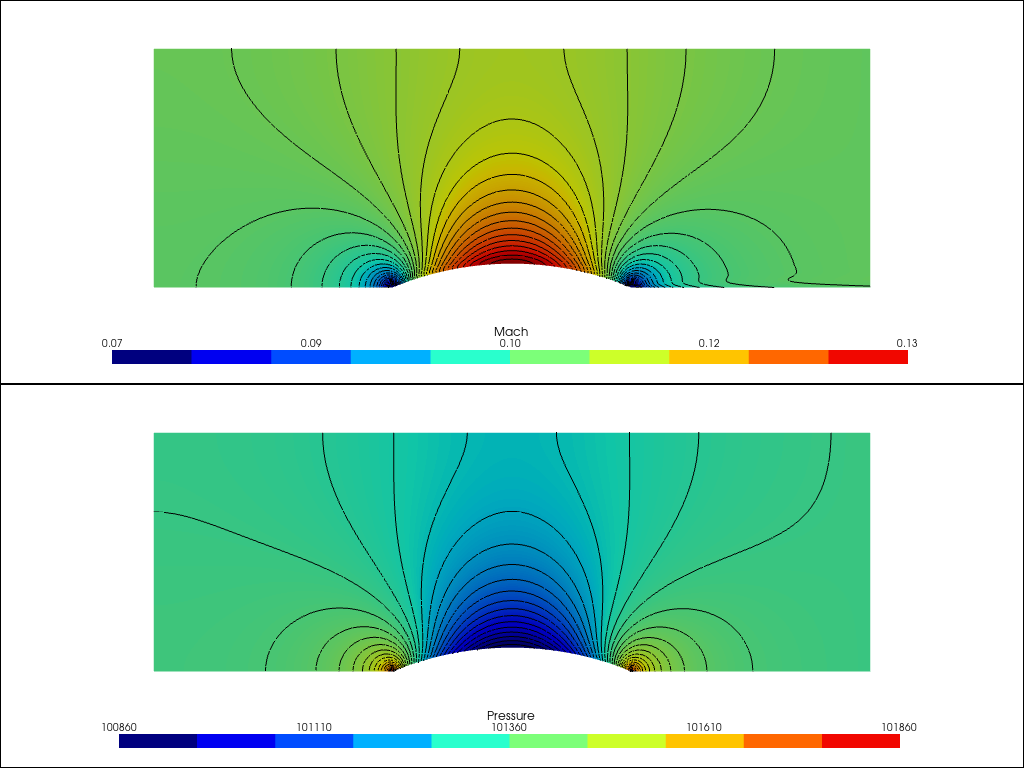

In [27]:
cpos = ((1.5, 0.4, 3.0),
        (1.5, 0.4, 0.0), 
        (0.0, 0.0, 0.0))

opts = dict(
    cmap="jet",
    pbr=False,
    scalar_bar_args=dict(
        height=0.1,
        width=0.8, 
        vertical=False, 
        position_x=0.1,
        position_y=0.05,
        color="k",
        n_colors=10
    )
)

p = pv.Plotter(shape="1/1", notebook=True)
p.set_background(color="w")

lims = (100860, 101860)
opts["scalar_bar_args"]["fmt"] = "%.0f"
contour = grid.contour(40, scalars="Pressure", rng=lims)

p.subplot(0)
p.add_mesh(grid.copy(), **opts, scalars="Pressure", clim=lims)
p.add_mesh(contour, color="k", line_width=1)

lims = (0.07, 0.13)
opts["scalar_bar_args"]["fmt"] = "%.2f"
contour = grid.contour(40, scalars="Mach", rng=lims)

p.subplot(1)
p.add_mesh(grid.copy(), **opts, scalars="Mach", clim=lims)
p.add_mesh(contour, color="k", line_width=1)

p.link_views()
p.show(cpos=cpos)

Now you can check these results against the [reference](https://su2code.github.io/tutorials/Inviscid_Bump/).

Hope you have enjoyed, see you next time!